In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *
import sys

# Lambda_idx = int(sys.argv[1])
# n_external = int(sys.argv[2])


Lambda_idx = 18
n_external = 3000

Lambda = Lambdas[Lambda_idx]

# CCAT-prime
zmin = 3.5
zmax = 8.1

oup_fname = '/scratch/users/delon/LIMxCMBL/I_auto/comb_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_quad.npy'%(zmin, zmax, 
                                                                                                                     Lambda_idx, 
                                                                                                                     n_external)
print(oup_fname)

/scratch/users/delon/LIMxCMBL/I_auto/comb_zmin_3.5_zmax_8.1_Lambda_idx_18_n_ext_3000_quad.npy


In [2]:
Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [3]:
from scipy.interpolate import interp1d, LinearNDInterpolator
from scipy.integrate import quad, quad_vec, trapezoid


inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')
tmp_chibs = []
tmp_log_deltas = []
tmp_fnctn = []
for i in range(len(chibs)):
    for j in range(len(deltas)):
        tmp_chibs += [chibs[i]]
        tmp_log_deltas += [np.log10(deltas[j])]
        tmp_fnctn += [inner_dkparp_integral[:,i,j]]
        
f_inner_integral = LinearNDInterpolator(list(zip(tmp_chibs, tmp_log_deltas)), tmp_fnctn)
f_inner_integral_LoLo = interp1d(x = chibs, y = inner_dkparp_integral, axis = 1)

In [4]:
import jax
import jax.numpy as jnp
_KI = np.array(KI)
@jax.jit
def f_KILo(chi, external_chi, Lambda):
    return (Lambda / jnp.pi 
            * jnp.interp(x = chi, xp = chis, 
                         fp = _KI, left = 0, right = 0) 
            * jnp.sinc(Lambda * (external_chi - chi) / np.pi))

In [5]:
from interpax import interp2d, interp1d
inner_dkparp_integral = jnp.array(inner_dkparp_integral.astype(np.float64))

2025-03-03 20:53:41.148275: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [66]:
chunk_size = 250
_external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
print('external chi spacing', np.mean(np.diff(_external_chis)))
dchi = np.mean(np.diff(_external_chis))

external chi spacing 0.7367582069534145


In [67]:
_external_chis[323]

7201.70764259943

In [68]:
chimin*(1+1e-8) + dchi * 323

7201.70764259943

In [69]:
from tqdm import trange

@jax.jit
def f_integrand(_chib, 
                ichunk,
                jchunk,
                ell_idx):
#     external_chis  = _external_chis[ichunk:ichunk+chunk_size]
#     external_chips = _external_chis[jchunk:jchunk+chunk_size]
    external_chis = jnp.linspace(chimin*(1+1e-8) + dchi * ichunk,
                                chimin*(1+1e-8) + dchi * (ichunk + chunk_size),
                                 chunk_size)
    external_chips = jnp.linspace(chimin*(1+1e-8) + dchi * jchunk,
                                chimin*(1+1e-8) + dchi * (jchunk + chunk_size),
                                 chunk_size)
    
    #by construction chimin < exteranl_chis < chimax 
    #I Lo + Lo I
    
    _delta = jnp.abs(1 - external_chis/_chib) #(n_ext)
    _delta = jnp.where(_delta < 1e-6, 1e-6, 
                     jnp.where(_delta > 0.7, 0.7, _delta))
    
    _idx = ((chimin <= 2*_chib - external_chis) 
            & (2*_chib - external_chis <= chimax)) #(n_ext)
    
    cross_integrand = (2 * jnp.interp(x = external_chis, xp = chis, fp = _KI, left = 0, right = 0) 
                       * interp2d(xq = _chib, yq=jnp.log(_delta), 
                           x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral[ell_idx],
                           method='linear',) 
                       / (_chib**2))
    
    cross_integrand = jnp.where(_idx.reshape(-1, 1),
                               cross_integrand.reshape(-1, 1)
                               * f_KILo(2*_chib - external_chis.reshape(-1,1), 
                                        external_chi = external_chips.reshape(1, -1), 
                                        Lambda=Lambda),
                                0)    

    _delta = jnp.abs(1 - external_chips/_chib) #(n_ext)
    _delta = jnp.where(_delta < 1e-6, 1e-6, 
                     jnp.where(_delta > 0.7, 0.7, _delta))
    
    _idx = ((chimin <= 2*_chib - external_chips) 
            & (2*_chib - external_chips <= chimax)) #(n_ext)
    
    cross_integrand2 = (2 * jnp.interp(x = external_chips, xp = chis, fp = _KI, left = 0, right = 0) 
                       * interp2d(xq = _chib, yq=jnp.log(_delta), 
                           x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral[ell_idx],
                           method='linear',) 
                       / (_chib**2))
    
    cross_integrand2 = jnp.where(_idx.reshape(1, -1),
                               cross_integrand2.reshape(1, -1)
                               * f_KILo(2*_chib - external_chips.reshape(1,-1), 
                                        external_chi = external_chis.reshape(-1, 1), 
                                        Lambda=Lambda),
                                0)    
    
    
    plus = _chib*(1+deltas)
    mins = _chib*(1-deltas)
    _idxs = (chimin < plus) & (plus < chimax) & (chimin < mins) & (mins < chimax)
    
    LoLo_integrand  = jnp.where(_idxs,
                               f_KILo(plus, 
                                      external_chi = external_chis.reshape(-1, 1, 1), 
                                      Lambda=Lambda) 
                                * f_KILo(mins, 
                                         external_chi = external_chips.reshape(1, -1, 1), 
                                         Lambda=Lambda),
                               0)
    LoLo_integrand += jnp.where(_idxs,
                               f_KILo(mins, 
                                      external_chi = external_chis.reshape(-1, 1, 1), 
                                      Lambda=Lambda) 
                                * f_KILo(plus, 
                                         external_chi = external_chips.reshape(1, -1, 1), 
                                         Lambda=Lambda),0)
    LoLo_integrand *= (2 / _chib) #(x,y,d)
    LoLo_integrand = jnp.einsum('xyd,d->xyd', LoLo_integrand, deltas)
    LoLo_integrand = jnp.einsum('xyd,d->xyd', LoLo_integrand, 
                                interp1d(xq = _chib,
                                         x = chibs, f=inner_dkparp_integral[ell_idx],
                                         method='linear',))
    
    LoLo_integrand = jnp.trapezoid(x = np.log(deltas), y = LoLo_integrand, axis=-1)

    return LoLo_integrand - (cross_integrand + cross_integrand2)

In [70]:
f_integrand(8080,
            0,
            0,
            ell_idx = 0)

Array([[ 1.3566800e-12,  1.3581881e-12,  1.3596236e-12, ...,
        -2.9269472e-13, -3.0463371e-13, -3.1656313e-13],
       [ 1.3581881e-12,  1.3597417e-12,  1.3612224e-12, ...,
        -2.8609558e-13, -2.9805647e-13, -3.1000810e-13],
       [ 1.3596236e-12,  1.3612224e-12,  1.3627483e-12, ...,
        -2.7947189e-13, -2.9145401e-13, -3.0342723e-13],
       ...,
       [-2.9269472e-13, -2.8609558e-13, -2.7947189e-13, ...,
         1.1600777e-12,  1.1613165e-12,  1.1624917e-12],
       [-3.0463371e-13, -2.9805647e-13, -2.9145401e-13, ...,
         1.1613165e-12,  1.1626623e-12,  1.1639443e-12],
       [-3.1656313e-13, -3.1000810e-13, -3.0342723e-13, ...,
         1.1624917e-12,  1.1639443e-12,  1.1653332e-12]], dtype=float32)

In [71]:
oup = np.zeros((len(ells), n_external, n_external))

In [72]:
from tqdm import trange

In [73]:
from quadax import quadgk

ell_idx = 64

for ichunk in range(0, n_external, chunk_size):
    for jchunk in trange(ichunk, n_external, chunk_size):
        res, _ = quadgk(f_integrand, jnp.hstack([10, jnp.linspace(chimin, chimax, 50), chimax_sample]),
                         epsabs = 0.0, epsrel = 1e-5, 
                        order = 61, max_ninter=10000, 
                        args=(ichunk,
                              jchunk,
                              ell_idx,))
        oup[ell_idx, ichunk:ichunk+chunk_size, jchunk:jchunk+chunk_size] = res
        oup[ell_idx, jchunk:jchunk+chunk_size, ichunk:ichunk+chunk_size] = res.T

100%|██████████| 1/1 [00:06<00:00,  6.36s/it]


In [74]:
np.save(oup_fname, res)
print('outputted')

outputted


In [75]:
import matplotlib.pyplot as plt

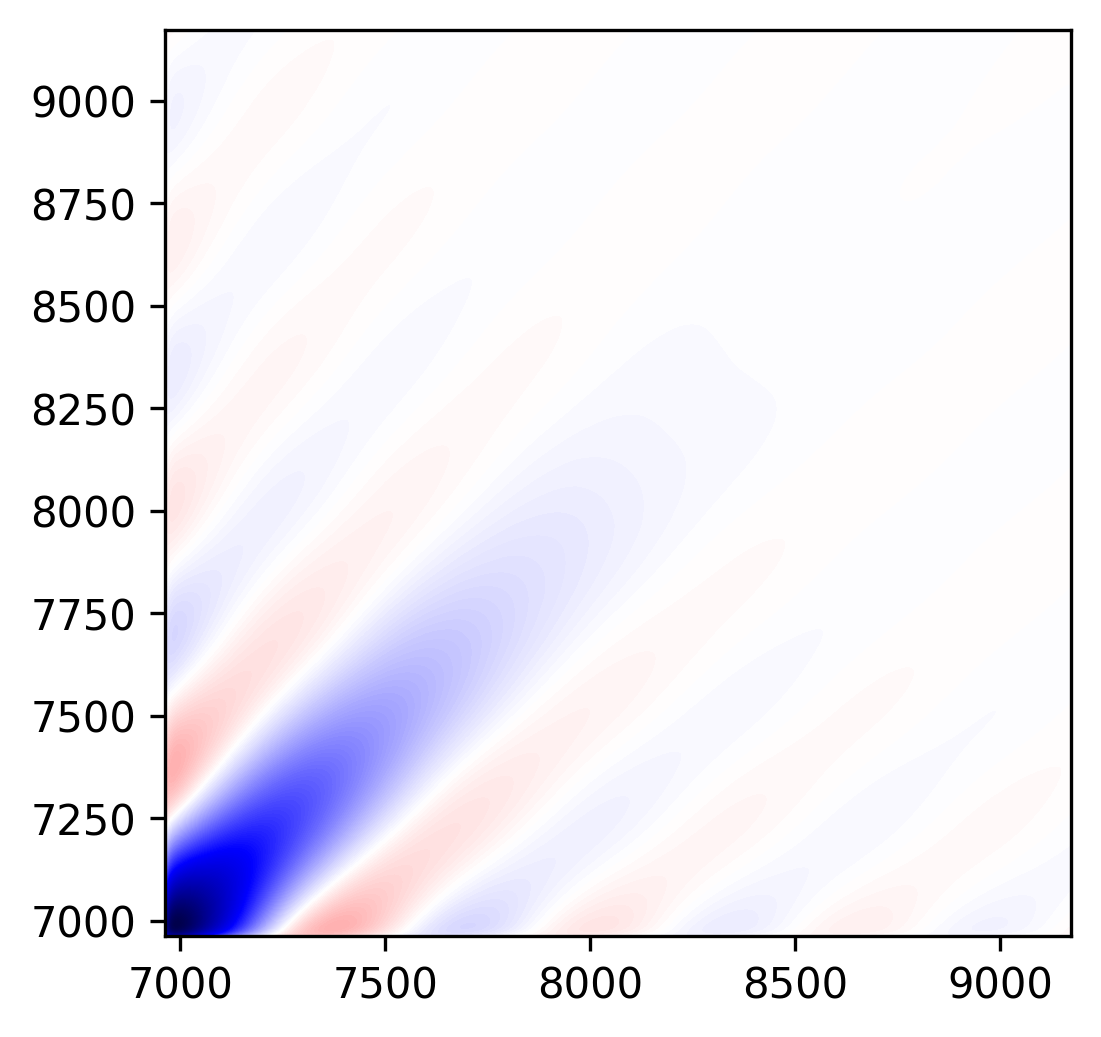

In [76]:
vb = np.max(np.abs(oup[ell_idx]))
plt.figure(dpi = 300)
plt.imshow(oup[ell_idx],
          vmin = -vb,
          vmax = vb,
           extent=[
               chimin,
               chimax,
               chimin,
               chimax
           ],
           origin = 'lower',
          cmap = 'seismic')